# Final Project: Load balancing
## Part 3 : Model-free control with Value Function/Policy approximation

#### Policy Approximation: softmax parametrization

Author : Jed MOUTAHIR

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 0
        self.Q2 = 0
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return - (self.state[0] + self.state[1])
    
    def step(self, action):
        # Take action (0 or 1) and return reward.
        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        elif(event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        elif(self.Q1 < self.Q1_max and self.Q2 < self.Q2_max and event < self.mu1 + self.mu2 + self.lambdA):
            # Choose queue
            if(self.Q1 == self.Q1_max):
                self.Q2 += 1
            elif(self.Q2 == self.Q2_max):
                self.Q1 += 1
            elif(action == 0):
                self.Q1 += 1
            elif(action == 1):
                self.Q2 += 1
        else:
            if((self.Q1 > self.Q1_max or self.Q2 > self.Q2_max) and (event < self.mu1 + self.mu2 + self.lambdA)):
                print("Error: impossible state : ")
                print("Q1 = ", self.Q1)
                print("Q2 = ", self.Q2)
                print("event = ", event)
                print("action = ", action)
                print("lambdA = ", self.lambdA)
                print("mu1 = ", self.mu1)
                print("mu2 = ", self.mu2)

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [18]:
def softmax_policy(theta, state, action):
    return np.exp(theta[state[0], state[1], action]) / (np.exp(theta[state[0], state[1], 0]) + np.exp(theta[state[0], state[1], 1]))

In [48]:
def softmax_approximation(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, num_episodes, learning_rate=0.0001, eps=1e-5):
    """ Function approxiamted the optimal policy using softmax approximation. """

    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)

    # Initialize theta
    theta = np.random.rand((env.Q1_max + 1), (env.Q2_max + 1), len(env.actions))

    for episode in range(num_episodes):
        # Initialize state
        state = (np.random.randint(env.Q1_max + 1), np.random.randint(env.Q2_max + 1))
        env.state = state
        env.Q1 = state[0]
        env.Q2 = state[1]

        # Get action probabilities
        action_probs = np.array([softmax_policy(theta, state, action) for action in env.actions])

        # Choose action
        action = np.random.choice(env.actions, p=action_probs)

        # Take action
        reward, next_state = env.step(action)

        # Update theta
        d_log_softmax = np.zeros_like(theta)
        d_log_softmax[state[0], state[1], action] = 1 - softmax_policy(theta, state, action)

        theta[state[0], state[1], action] += learning_rate * d_log_softmax[state[0], state[1], action] * reward * d_log_softmax[state[0], state[1], action]

    return theta

In [67]:
def softmax_approximation(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N, alpha=0.1, temperature=1.0, eps=1e-5):
    """ Function that implements policy approximation with softmax parameterization. """


    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)
    
    Q1_max += 1  # Include state Q1_max in the state space
    Q2_max += 1  # Include state Q2_max in the state space

    # Initialize value function with zeros
    V = np.zeros((Q1_max, Q2_max))

    # Initialize policy with zeros
    policy = np.ones((Q1_max, Q2_max, 2)) * 0.5  # Softmax policy parameterized by temperature

    for k in range(N):
        # Random initial state
        state = (np.random.randint(0, Q1_max), np.random.randint(0, Q2_max))
        
        for t in range(100):
            # Choose action based on softmax policy
            action_probs = np.exp(policy[state[0], state[1], :] / temperature) / \
                           np.sum(np.exp(policy[state[0], state[1], :] / temperature))
            
            if(np.isnan(action_probs[0]) or np.isnan(action_probs[1])):
                action_probs = np.array([0.5, 0.5])

            action = np.random.choice([0, 1], p=action_probs)

            # Next state and reward
            reward, next_state = env.step(action)

            # Update value function
            V[state[0], state[1]] += alpha * (reward + gamma * V[next_state[0], next_state[1]] - V[state[0], state[1]])

            # Update policy
            visit_count = np.sum(policy[state[0], state[1], :])
            policy[state[0], state[1], action] += alpha / np.log(np.log(visit_count + 2)) * \
                                                   (reward - V[state[0], state[1]])

            state = next_state


    # Compute optimal policy
    policy = np.zeros((Q1_max, Q2_max))
    Q1_max -= 1
    Q2_max -= 1
    for i in np.arange(Q1_max+1):
        for j in np.arange(Q2_max+1):
            if(i == Q1_max):
                policy[i, j] = 1
            elif(j == Q2_max):
                policy[i, j] = 0
            else:
                if(V[i + 1, j] < V[i, j + 1]):
                    policy[i, j] = 0
                else:
                    policy[i, j] = 1



    return V, policy


In [68]:
# Parameters
lambdA = 0.3
mu1 = 0.2
mu2 = 0.4
gamma = 0.99
Q1_max = 20
Q2_max = 20

In [75]:
# Compute optimal policy and value function
N = 100000
V, policy = softmax_approximation(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N, alpha=0.1, temperature=1.0, eps=1e-5)

C:\Users\mouta\AppData\Local\Temp\ipykernel_17036\3621984577.py:39: RuntimeWarning: invalid value encountered in log
  policy[state[0], state[1], action] += alpha / np.log(np.log(visit_count + 2)) * \
C:\Users\mouta\AppData\Local\Temp\ipykernel_17036\3621984577.py:23: RuntimeWarning: overflow encountered in exp
  action_probs = np.exp(policy[state[0], state[1], :] / temperature) / \
C:\Users\mouta\AppData\Local\Temp\ipykernel_17036\3621984577.py:24: RuntimeWarning: overflow encountered in exp
  np.sum(np.exp(policy[state[0], state[1], :] / temperature))
C:\Users\mouta\AppData\Local\Temp\ipykernel_17036\3621984577.py:23: RuntimeWarning: invalid value encountered in divide
  action_probs = np.exp(policy[state[0], state[1], :] / temperature) / \


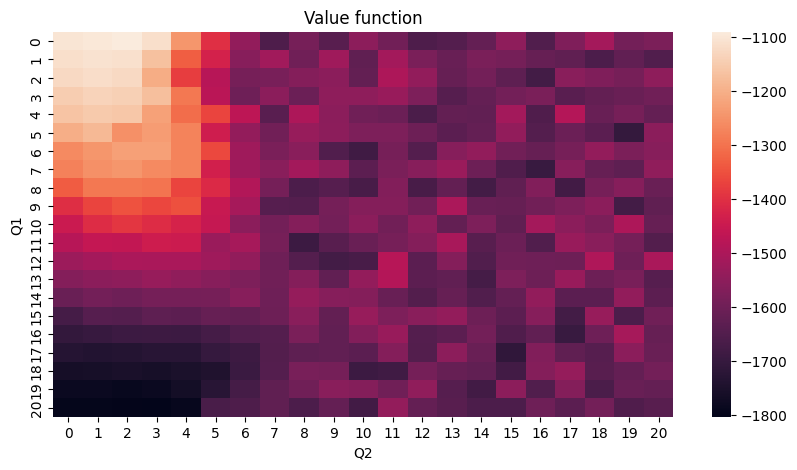

In [78]:
# Plot the value function using sns
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(V, annot=False, ax=ax)
plt.title("Value function")
plt.xlabel("Q2")
plt.ylabel("Q1")
plt.savefig("softmax_value_function_ln.png")
plt.show()

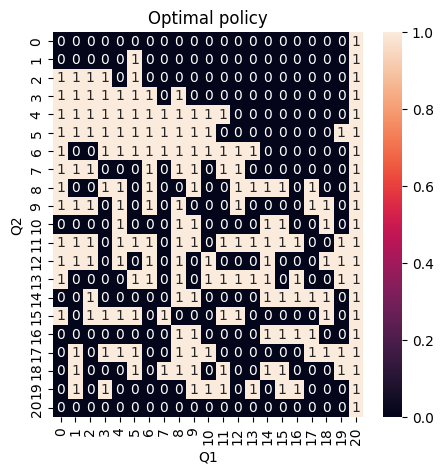

In [79]:
# Plot the optimal policy
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(policy.T, annot=True, ax=ax)
ax.set_title("Optimal policy")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.savefig("softmax_optimal_policy_ln.png")
plt.show()

In [50]:
# Compute the corresponding theta using softmax approximation
N = 1000000
theta = softmax_approximation(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N)

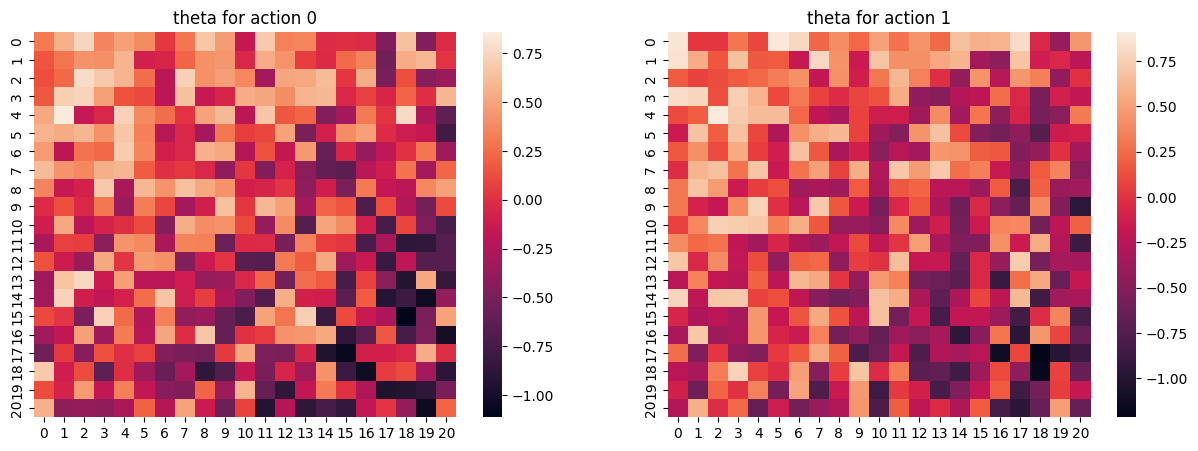

In [51]:
# plot both theta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(theta[:, :, 0], ax=ax[0])
ax[0].set_title("theta for action 0")
sns.heatmap(theta[:, :, 1], ax=ax[1])
ax[1].set_title("theta for action 1")
plt.show()

In [52]:
# Compute the policy for each state
policy = np.zeros((Q1_max + 1, Q2_max + 1))
for Q1 in range(Q1_max + 1):
    for Q2 in range(Q2_max + 1):
        policy[Q1, Q2] = np.argmax([softmax_policy(theta, (Q1, Q2), action) for action in range(2)])

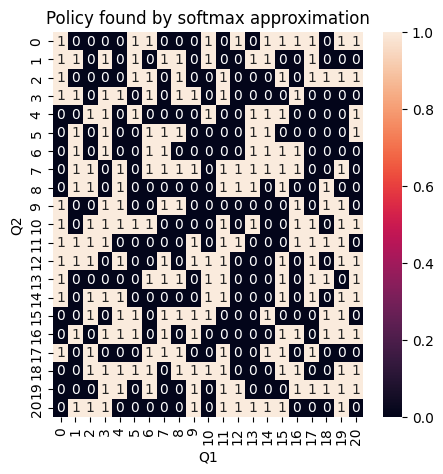

In [53]:
# Plot the policy found by softmax approximation
plt.figure(figsize=(5, 5))
sns.heatmap(policy, annot=True)
plt.title("Policy found by softmax approximation")
plt.xlabel("Q1")
plt.ylabel("Q2")
plt.show()